# Challenges local development

This notebook was used for locally developing Python code for the challenges. It also provides some visualizations.

## Setup

### Python environment

Create a Python 3.8 kernel.

In [1]:
# yolo
import warnings

warnings.simplefilter("ignore")

## Installs

In [2]:
#%pip install --upgrade 'snowflake-snowpark-python[pandas]' pyyaml numpy pandas scikit-learn matplotlib seaborn prophet mlflow thefuzz ipympl

## Imports

In [3]:
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thefuzz import fuzz
from prophet import Prophet
from datetime import datetime
from sklearn.cluster import KMeans
from prophet.serialize import model_to_json, model_from_json
from snowflake.snowpark import Session
from sklearn.decomposition import PCA

from thefuzz.process import extractOne

Importing plotly failed. Interactive plots will not work.


## Connect to Snowpark in Python

In [4]:
# replace as needed
PROFILE_PATH = "/root/.dbt/profiles.yml"
PROFILE_NAME = "snowflake"
PROFILE_OUTPUT = "dev"

# read in dbt profile
with open(PROFILE_PATH, "r") as f:
    profiles = yaml.safe_load(f)
    profile = profiles[PROFILE_NAME]["outputs"][PROFILE_OUTPUT]

# build connection parameters from profile
conn_params = {
    "account": profile["account"],
    "user": profile["user"],
    "role": profile["role"],
    "warehouse": profile["warehouse"],
    "database": profile["database"],
    "schema": profile["schema"],
    "authenticator": profile["authenticator"],
}

In [5]:
schema = conn_params["schema"]

In [6]:
from snowflake.snowpark import Session

s = Session.builder.configs(conn_params).create()
s

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [7]:
s.sql("select current_warehouse(), current_database(), current_schema()").collect()

[Row(CURRENT_WAREHOUSE()='TRANSFORMING', CURRENT_DATABASE()='ANALYTICS', CURRENT_SCHEMA()='DBT_CODY')]

## Challenge 1: describe the data

In [8]:
orders = s.table(f"{schema}.orders").sample(frac=0.1).to_pandas()
orders.head()

,LOCATION_ID,ORDER_ID,ORDER_TOTAL,TAX_PAID,ORDERED_AT,CUSTOMER_NAME,CUSTOMER_ID_MATCH,CUSTOMER_NAME_MATCH,MATCH_LIKELIHOOD,COUNT_FOOD_ITEMS,...,COUNT_ITEMS,SUBTOTAL_DRINK_ITEMS,SUBTOTAL_FOOD_ITEMS,SUBTOTAL,ORDER_COST,CUSTOMER_ORDER_INDEX,LOCATION_NAME,IS_FIRST_ORDER,IS_FOOD_ORDER,IS_DRINK_ORDER
0,fb199829-e587-4d3e-8de0-efc0156c0d48,c90b8aec-ffa8-4009-a0d3-fb099d05eb02,45.68,2.68,2018-05-10 08:54:00,aaron Ellis,9df84231-f9dc-4305-aa25-110e6f98a84c,Aaron Ellis,0.909091,3,...,5,34.0,9.0,43.0,9.76,6,Chicago,False,True,True
1,fb199829-e587-4d3e-8de0-efc0156c0d48,b725d16e-cd8d-4bb8-beff-f882dd957dc5,11.68,0.68,2018-05-29 12:00:00,aARON Ellis,9df84231-f9dc-4305-aa25-110e6f98a84c,Aaron Ellis,0.545455,0,...,2,0.0,11.0,11.0,1.45,10,Chicago,False,False,True
2,fb199829-e587-4d3e-8de0-efc0156c0d48,b46b82db-ebee-4a15-a749-83d2d079bf91,27.62,1.62,2018-06-16 13:22:00,Aaron ELLIW,9df84231-f9dc-4305-aa25-110e6f98a84c,Aaron Ellis,0.636364,2,...,2,26.0,0.0,26.0,7.09,13,Chicago,False,True,False
3,1f52874a-0461-4cfb-9fa7-9e39eab2cfda,e43a5d99-5097-47bd-9ad6-90feab671ab6,5.20,0.20,2018-07-12 08:47:00,haron gEORGE,9df84231-f9dc-4305-aa25-110e6f98a84c,Aaron Ellis,0.500000,0,...,1,0.0,5.0,5.0,1.75,18,Brooklyn,False,False,True
4,fb199829-e587-4d3e-8de0-efc0156c0d48,1d7e98b6-f5a7-4388-84a3-5e0bc9b94109,21.25,1.25,2018-07-12 13:52:00,Aaron ellis,9df84231-f9dc-4305-aa25-110e6f98a84c,Aaron Ellis,0.909091,1,...,3,11.0,9.0,20.0,4.89,19,Chicago,False,True,True


In [9]:
described = orders.describe()
described.head()

,ORDER_TOTAL,TAX_PAID,MATCH_LIKELIHOOD,COUNT_FOOD_ITEMS,COUNT_DRINK_ITEMS,COUNT_ITEMS,SUBTOTAL_DRINK_ITEMS,SUBTOTAL_FOOD_ITEMS,SUBTOTAL,ORDER_COST,CUSTOMER_ORDER_INDEX
count,181443.000000,181443.000000,109040.000000,181443.000000,181443.000000,181443.000000,181443.000000,181443.000000,181443.000000,181443.000000,181443.000000
mean,13.111989,0.682713,0.703254,0.490170,1.168461,1.658631,5.883964,6.544739,12.428702,2.595165,143458.801287
std,12.515821,0.691525,0.159496,0.845043,0.612553,1.203606,10.174336,3.604472,11.861679,2.666838,219594.768573
min,4.160000,0.160000,0.500000,0.000000,0.000000,1.000000,0.000000,0.000000,4.000000,0.630000,1.000000
25%,6.240000,0.280000,0.571429,0.000000,1.000000,1.000000,0.000000,5.000000,6.000000,0.820000,177.000000


## Challenge 2: pivot the data

In [10]:
order_items = s.table(f"{schema}.stg_order_items").sample(frac=0.1).to_pandas()
order_items.head()

,ORDER_ITEM_ID,ORDER_ID,PRODUCT_ID
0,5f065359-bc64-4998-8ba8-ac6b29d16a80,2fc8ad8b-6497-42fc-9f4c-a2d7104477f9,BEV-005
1,e76a1639-2093-4717-a81d-a5e136d6b47c,a37ad1ea-1b56-42e4-8034-7b0070bccfbb,BEV-005
2,99c2cfdf-e653-4bfa-961d-5a888796b00b,f69c81cc-2c23-4d59-9646-6fde19af80bd,BEV-004
3,eee9c030-467b-4e13-9603-f975e229e01f,28d1106d-2e30-4722-8f50-55da7199d829,BEV-005
4,4e546a93-389d-4146-928c-b3f33bf09281,595871b2-2b33-4c10-a1c2-61d9eba52d43,BEV-004


In [11]:
products = s.table(f"{schema}.stg_products").to_pandas()
products.head()

,PRODUCT_ID,PRODUCT_NAME,PRODUCT_TYPE,PRODUCT_DESCRIPTION,PRODUCT_PRICE,IS_FOOD_ITEM,IS_DRINK_ITEM
0,JAF-001,nutellaphone who dis?,jaffle,nutella and banana jaffle,11.0,1,0
1,JAF-002,doctor stew,jaffle,house-made beef stew jaffle,11.0,1,0
2,JAF-003,the krautback,jaffle,lamb and pork bratwurst with house-pickled cab...,12.0,1,0
3,JAF-004,flame impala,jaffle,pulled pork and pineapple al pastor marinated ...,14.0,1,0
4,JAF-005,mel-bun,jaffle,"melon and minced beef bao, in a jaffle, savory...",12.0,1,0


In [12]:
product_ids = sorted(list(set(products["product_id".upper()].unique())))
product_ids

['BEV-001',
 'BEV-002',
 'BEV-003',
 'BEV-004',
 'BEV-005',
 'JAF-001',
 'JAF-002',
 'JAF-003',
 'JAF-004',
 'JAF-005']

In [13]:
order_item_product_subtotals = (
    order_items.merge(products, on="product_id".upper())
    .groupby(
        ["order_id".upper(), "product_id".upper()],
        as_index=False,
    )
    .agg(SUBTOTAL=("product_price".upper(), "sum"))
    .reset_index()
    .pivot(
        index="order_id".upper(),
        columns="product_id".upper(),
        values="subtotal".upper(),
    )
    .reset_index()
)
order_item_product_subtotals.head()

PRODUCT_ID,ORDER_ID,BEV-001,BEV-002,BEV-003,BEV-004,BEV-005,JAF-001,JAF-002,JAF-003,JAF-004,JAF-005
0,000003bf-0210-46e4-8303-3bd4635cdf61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN
1,00000871-b2f0-420e-b6ee-244d26d440af,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000009dd-3156-4188-83a0-66eb275093e6,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000087a5-928d-4e41-bbff-6834375b9d1b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN
4,0000c288-99a8-4ffc-977d-dbe398c9b467,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
renames = {product_id: f"subtotal_{product_id}".upper() for product_id in product_ids}
order_item_product_subtotals = order_item_product_subtotals.rename(columns=renames)
order_item_product_subtotals.head()

PRODUCT_ID,ORDER_ID,SUBTOTAL_BEV-001,SUBTOTAL_BEV-002,SUBTOTAL_BEV-003,SUBTOTAL_BEV-004,SUBTOTAL_BEV-005,SUBTOTAL_JAF-001,SUBTOTAL_JAF-002,SUBTOTAL_JAF-003,SUBTOTAL_JAF-004,SUBTOTAL_JAF-005
0,000003bf-0210-46e4-8303-3bd4635cdf61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN
1,00000871-b2f0-420e-b6ee-244d26d440af,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000009dd-3156-4188-83a0-66eb275093e6,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000087a5-928d-4e41-bbff-6834375b9d1b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN
4,0000c288-99a8-4ffc-977d-dbe398c9b467,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
order_item_product_subtotals = order_item_product_subtotals.fillna(0)
order_item_product_subtotals.head()

PRODUCT_ID,ORDER_ID,SUBTOTAL_BEV-001,SUBTOTAL_BEV-002,SUBTOTAL_BEV-003,SUBTOTAL_BEV-004,SUBTOTAL_BEV-005,SUBTOTAL_JAF-001,SUBTOTAL_JAF-002,SUBTOTAL_JAF-003,SUBTOTAL_JAF-004,SUBTOTAL_JAF-005
0,000003bf-0210-46e4-8303-3bd4635cdf61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0
1,00000871-b2f0-420e-b6ee-244d26d440af,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000009dd-3156-4188-83a0-66eb275093e6,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,000087a5-928d-4e41-bbff-6834375b9d1b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0
4,0000c288-99a8-4ffc-977d-dbe398c9b467,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
orders_with_subtotals = orders.merge(
    order_item_product_subtotals, on="order_id".upper()
)
orders_with_subtotals.tail()

,LOCATION_ID,ORDER_ID,ORDER_TOTAL,TAX_PAID,ORDERED_AT,CUSTOMER_NAME,CUSTOMER_ID_MATCH,CUSTOMER_NAME_MATCH,MATCH_LIKELIHOOD,COUNT_FOOD_ITEMS,...,SUBTOTAL_BEV-001,SUBTOTAL_BEV-002,SUBTOTAL_BEV-003,SUBTOTAL_BEV-004,SUBTOTAL_BEV-005,SUBTOTAL_JAF-001,SUBTOTAL_JAF-002,SUBTOTAL_JAF-003,SUBTOTAL_JAF-004,SUBTOTAL_JAF-005
27834,1f52874a-0461-4cfb-9fa7-9e39eab2cfda,b17aecdc-2062-493f-a4e1-1c603c5d0e3b,7.28,0.28,2020-11-26 07:40:00,Dana wOLFE,b71ff4f6-57ca-4be7-aa0f-c36c9ece1728,Dana Wolfe,0.5,0,...,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
27835,1f52874a-0461-4cfb-9fa7-9e39eab2cfda,ebe7628f-1180-4f72-a9e0-6e095d89bac9,6.24,0.24,2021-02-26 08:15:00,Dana wolfe,b71ff4f6-57ca-4be7-aa0f-c36c9ece1728,Dana Wolfe,0.9,0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27836,1f52874a-0461-4cfb-9fa7-9e39eab2cfda,b8610a6a-521e-419c-87af-9009ab71a426,6.24,0.24,2021-03-26 07:55:00,Dana VQLFE,b71ff4f6-57ca-4be7-aa0f-c36c9ece1728,Dana Wolfe,0.5,0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27837,1f52874a-0461-4cfb-9fa7-9e39eab2cfda,d22a73e3-ae3d-491e-9628-19616ecc05f4,7.28,0.28,2022-02-14 08:20:00,Daqa WOLFE,b71ff4f6-57ca-4be7-aa0f-c36c9ece1728,Dana Wolfe,0.5,0,...,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
27838,1f52874a-0461-4cfb-9fa7-9e39eab2cfda,aff50a37-1a61-4570-81b8-96ccd52d8621,6.24,0.24,2022-08-26 07:26:00,@^n^ wolfe,b71ff4f6-57ca-4be7-aa0f-c36c9ece1728,Dana Wolfe,0.6,0,...,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Challenge 3: flag fuzzy duplicates

In [17]:
customers = s.table(f"{schema}.int_customers").to_pandas()
customers.head()

,CUSTOMER_ID,CUSTOMER_NAME
0,15df7af1-ef13-473f-bbea-deedde94ac32,Samuel Stout
1,face746f-5b3a-4299-b3ea-a83c6a3a6712,James Gutierrez
2,e4a57063-7fff-4e07-acec-6c255e491a9b,Judy Alvarez
3,6338ad00-dbf7-419a-9882-be4926d0deff,Vanessa Howell
4,6d28d61c-33c4-4759-85ab-80dcd23e17ec,Alyssa Riddle


In [18]:
# use the earlier int_orders table that has the unmatch customer_names
orders = s.table(f"{schema}.int_orders").sample(n=40).to_pandas()
orders.head()

,ORDER_ID,LOCATION_ID,ORDER_TOTAL,TAX_PAID,ORDERED_AT,CUSTOMER_NAME
0,f3ea5561-7dbd-438f-a323-7a3693c9ed2e,eed97b42-081b-4ed8-b5e4-32a45659094d,6.45,0.44,1626937440000000,Davih meyer
1,e1a9b20e-b8dc-4f0f-b806-548aef7e27ae,fb199829-e587-4d3e-8de0-efc0156c0d48,6.37,0.37,1563304980000000,DAVID sMIT
2,0a2c2b36-c58e-4000-950a-305762bd122c,b8d4c6a3-41cd-42aa-857f-3183be9dca08,19.76,0.76,1663163040000000,CHRISUOPHER Rasnussen
3,5ba6c67d-0956-46d2-9acd-dc4fe70c928a,eed97b42-081b-4ed8-b5e4-32a45659094d,4.30,0.30,1535961540000000,mICHAE Lewis
4,a98c04ac-13dc-457d-9c2b-12c667a02bec,fb199829-e587-4d3e-8de0-efc0156c0d48,19.12,1.12,1582633980000000,bric montoya


In [19]:
unfuzzed = orders
names = sorted(list(customers["customer_name".upper()].unique()))
unfuzzed[["matched_name".upper(), "matched_likelihood".upper()]] = unfuzzed.apply(
    lambda x: extractOne(x["customer_name".upper()], names),
    axis=1,
    result_type="expand",
)

unfuzzed.head()

,ORDER_ID,LOCATION_ID,ORDER_TOTAL,TAX_PAID,ORDERED_AT,CUSTOMER_NAME,MATCHED_NAME,MATCHED_LIKELIHOOD
0,f3ea5561-7dbd-438f-a323-7a3693c9ed2e,eed97b42-081b-4ed8-b5e4-32a45659094d,6.45,0.44,1626937440000000,Davih meyer,David Meyer,91
1,e1a9b20e-b8dc-4f0f-b806-548aef7e27ae,fb199829-e587-4d3e-8de0-efc0156c0d48,6.37,0.37,1563304980000000,DAVID sMIT,David Smith,95
2,0a2c2b36-c58e-4000-950a-305762bd122c,b8d4c6a3-41cd-42aa-857f-3183be9dca08,19.76,0.76,1663163040000000,CHRISUOPHER Rasnussen,Christopher Rasmussen,90
3,5ba6c67d-0956-46d2-9acd-dc4fe70c928a,eed97b42-081b-4ed8-b5e4-32a45659094d,4.30,0.30,1535961540000000,mICHAE Lewis,Michael Lewis,96
4,a98c04ac-13dc-457d-9c2b-12c667a02bec,fb199829-e587-4d3e-8de0-efc0156c0d48,19.12,1.12,1582633980000000,bric montoya,Eric Montoya,92


## Challenge 4: cluster customers by their order history

In [20]:
X = orders_with_subtotals.select_dtypes(include=["number"]).fillna(0).values
X

array([[45.68    ,  2.68    ,  0.909091, ...,  0.      ,  0.      ,
         0.      ],
       [11.68    ,  0.68    ,  0.545455, ...,  0.      ,  0.      ,
         0.      ],
       [11.68    ,  0.68    ,  0.545455, ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 6.24    ,  0.24    ,  0.5     , ...,  0.      ,  0.      ,
         0.      ],
       [ 7.28    ,  0.28    ,  0.5     , ...,  0.      ,  0.      ,
         0.      ],
       [ 6.24    ,  0.24    ,  0.6     , ...,  0.      ,  0.      ,
         0.      ]])

Detour: motivation!

In [21]:
n_components = 3
pca = PCA(n_components=n_components)
pca

PCA(n_components=3)

In [22]:
pca = pca.fit(X)
pca

PCA(n_components=3)

In [23]:
X_pca = pca.transform(X)
X_pca.shape

(27839, 3)

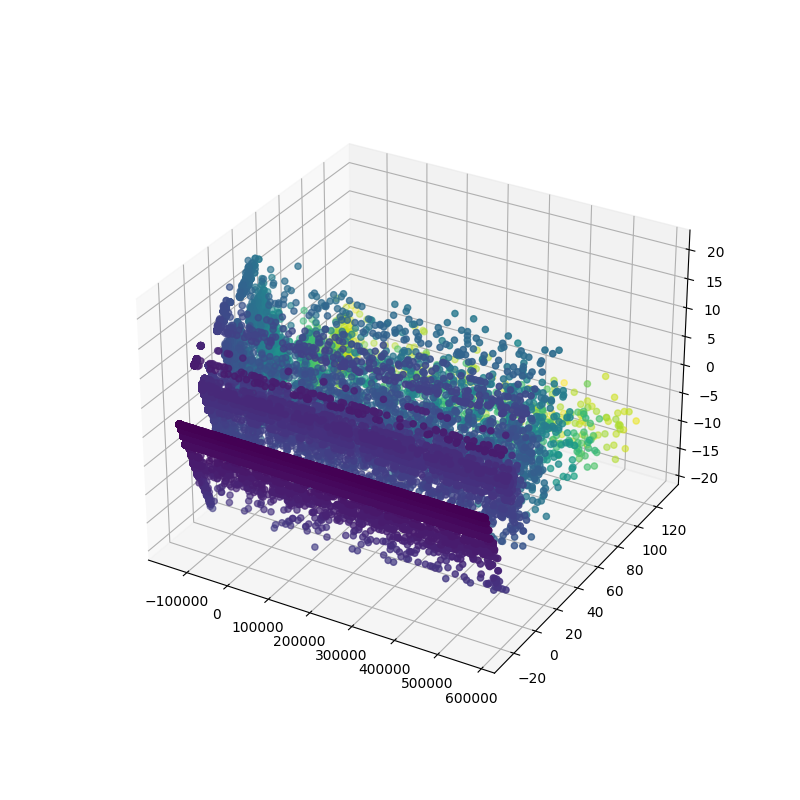

In [24]:
%matplotlib ipympl

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")

ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    X_pca[:, 2],
    c=orders_with_subtotals["subtotal".upper()].values,
)

In [25]:
model = KMeans(n_clusters=5)
model

KMeans(n_clusters=5)

In [26]:
model = model.fit(X)
model

KMeans(n_clusters=5)

In [27]:
cluster_labels = model.predict(X)
cluster_labels

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

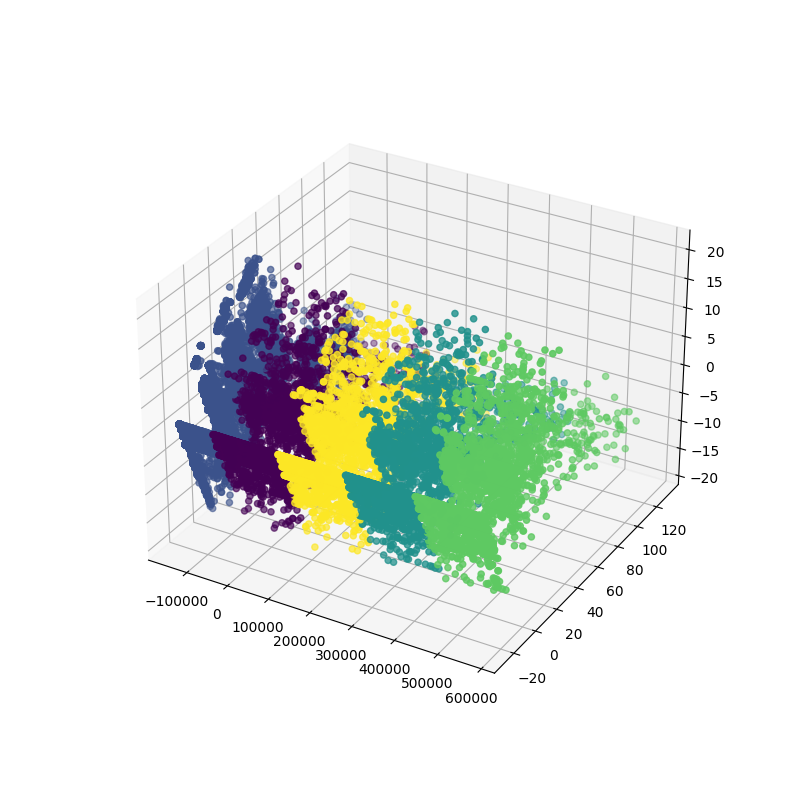

In [28]:
%matplotlib ipympl

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")

ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    X_pca[:, 2],
    c=cluster_labels,
)

In [29]:
temp = pd.DataFrame(data=cluster_labels, columns=["cluster_label"])
temp

,cluster_label
0,1
1,1
2,1
3,1
4,1
...,...
27834,1
27835,1
27836,1
27837,1


In [30]:
orders_with_subtotals_and_clusters = orders_with_subtotals.merge(
    temp, left_index=True, right_index=True
)
orders_with_subtotals_and_clusters.head()

,LOCATION_ID,ORDER_ID,ORDER_TOTAL,TAX_PAID,ORDERED_AT,CUSTOMER_NAME,CUSTOMER_ID_MATCH,CUSTOMER_NAME_MATCH,MATCH_LIKELIHOOD,COUNT_FOOD_ITEMS,...,SUBTOTAL_BEV-002,SUBTOTAL_BEV-003,SUBTOTAL_BEV-004,SUBTOTAL_BEV-005,SUBTOTAL_JAF-001,SUBTOTAL_JAF-002,SUBTOTAL_JAF-003,SUBTOTAL_JAF-004,SUBTOTAL_JAF-005,cluster_label
0,fb199829-e587-4d3e-8de0-efc0156c0d48,c90b8aec-ffa8-4009-a0d3-fb099d05eb02,45.68,2.68,2018-05-10 08:54:00,aaron Ellis,9df84231-f9dc-4305-aa25-110e6f98a84c,Aaron Ellis,0.909091,3,...,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,1
1,fb199829-e587-4d3e-8de0-efc0156c0d48,b725d16e-cd8d-4bb8-beff-f882dd957dc5,11.68,0.68,2018-05-29 12:00:00,aARON Ellis,9df84231-f9dc-4305-aa25-110e6f98a84c,Aaron Ellis,0.545455,0,...,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,fb199829-e587-4d3e-8de0-efc0156c0d48,5f2c35a9-f08d-42e2-803a-d670abfb8348,11.68,0.68,2018-12-06 15:17:00,AARON ellis,9df84231-f9dc-4305-aa25-110e6f98a84c,Aaron Ellis,0.545455,0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,fb199829-e587-4d3e-8de0-efc0156c0d48,2e4d765e-025a-4122-9c62-b1e72e6d94b7,35.06,2.06,2020-02-21 13:44:00,aron ELLIS,9df84231-f9dc-4305-aa25-110e6f98a84c,Aaron Ellis,0.545455,2,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,fb199829-e587-4d3e-8de0-efc0156c0d48,bdd753fb-f36d-43bb-b8d1-e38bf54b88bd,5.31,0.31,2020-05-27 07:45:00,Aaron lUNA,9df84231-f9dc-4305-aa25-110e6f98a84c,Aaron Ellis,0.636364,0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


## Challenge 5: predict revenue by location

In [31]:
revenue = s.table(f"{schema}.revenue_weekly_by_location").to_pandas()
revenue.head()

,DATE_WEEK,LOCATION_NAME,REVENUE
0,2022-10-03,San Francisco,18124.74
1,2022-10-03,Philadelphia,14860.18
2,2022-10-03,New Orleans,12099.00
3,2022-10-03,Chicago,20012.00
4,2022-10-03,Brooklyn,23346.09


In [32]:
renames = {
    "date_week".upper(): "ds",
    "location_name".upper(): "location",
    "revenue".upper(): "y",
}
revenue = revenue.rename(columns=renames)
revenue.head()

,ds,location,y
0,2022-10-03,San Francisco,18124.74
1,2022-10-03,Philadelphia,14860.18
2,2022-10-03,New Orleans,12099.00
3,2022-10-03,Chicago,20012.00
4,2022-10-03,Brooklyn,23346.09


In [33]:
locations = sorted(list(revenue["location"].unique()))
locations

['Brooklyn', 'Chicago', 'New Orleans', 'Philadelphia', 'San Francisco']

In [34]:
models = {
    location: Prophet().fit(revenue[revenue["location"] == location])
    for location in locations
}
models

06:21:18 - cmdstanpy - INFO - Chain [1] start processing
06:21:18 - cmdstanpy - INFO - Chain [1] done processing
06:21:18 - cmdstanpy - INFO - Chain [1] start processing
06:21:18 - cmdstanpy - INFO - Chain [1] done processing
06:21:18 - cmdstanpy - INFO - Chain [1] start processing
06:21:19 - cmdstanpy - INFO - Chain [1] done processing
06:21:19 - cmdstanpy - INFO - Chain [1] start processing
06:21:19 - cmdstanpy - INFO - Chain [1] done processing
06:21:19 - cmdstanpy - INFO - Chain [1] start processing
06:21:19 - cmdstanpy - INFO - Chain [1] done processing


{'Brooklyn': <prophet.forecaster.Prophet at 0x7f6326d0fa30>,
 'Chicago': <prophet.forecaster.Prophet at 0x7f6375987760>,
 'New Orleans': <prophet.forecaster.Prophet at 0x7f6326cacbe0>,
 'Philadelphia': <prophet.forecaster.Prophet at 0x7f6326d44e80>,
 'San Francisco': <prophet.forecaster.Prophet at 0x7f6326c93910>}

In [35]:
future = models[locations[0]].make_future_dataframe(periods=52 * 3, freq="W")
future.tail()

,ds
470,2025-08-31
471,2025-09-07
472,2025-09-14
473,2025-09-21
474,2025-09-28


In [36]:
forecasts = {location: models[location].predict(future) for location in locations}
forecasts

{'Brooklyn':             ds         trend    yhat_lower    yhat_upper   trend_lower  \
 0   2016-08-29  -4262.555995  -9571.695703  -5721.390905  -4262.555995   
 1   2016-09-05  -3926.619887  -8892.841196  -4918.987345  -3926.619887   
 2   2016-09-12  -3590.683779  -7440.443143  -3440.132455  -3590.683779   
 3   2016-09-19  -3254.747670  -5544.685109  -1465.407833  -3254.747670   
 4   2016-09-26  -2918.811562  -3673.816525    161.661940  -2918.811562   
 ..         ...           ...           ...           ...           ...   
 470 2025-08-31  30015.945553  17625.061449  35063.353546  21228.780506   
 471 2025-09-07  30033.906274  18337.524650  36376.790102  21162.831679   
 472 2025-09-14  30051.866995  19519.809418  37771.024356  21098.687114   
 473 2025-09-21  30069.827716  21011.729302  39342.232676  21002.247238   
 474 2025-09-28  30087.788437  21854.996813  40135.902707  20878.702985   
 
       trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
 0  

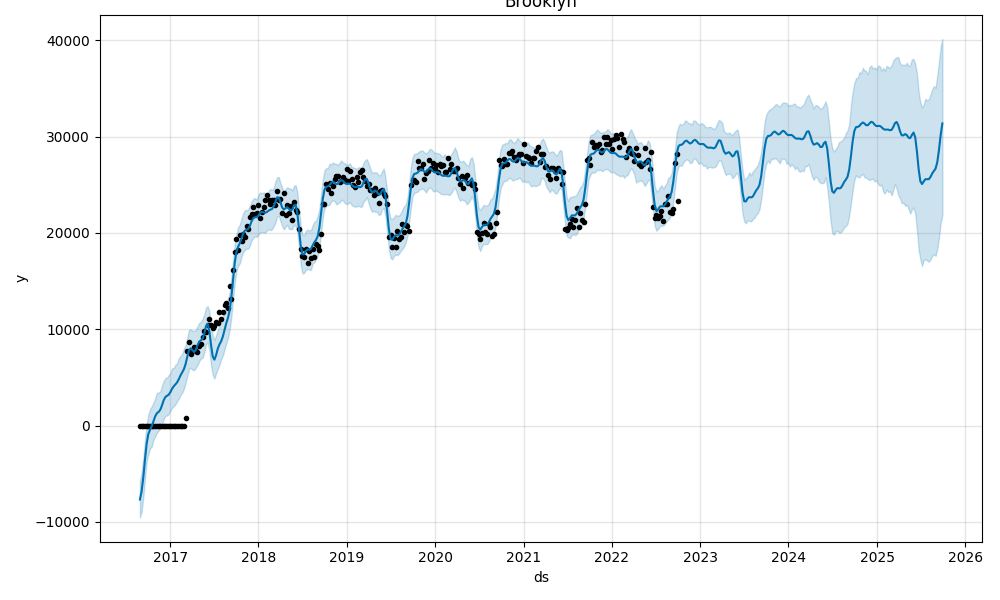

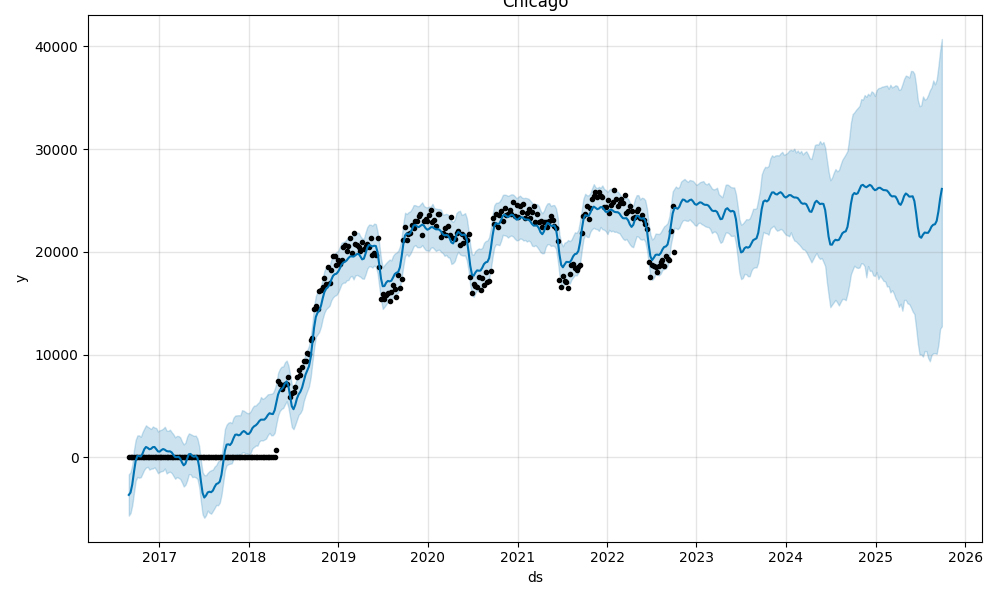

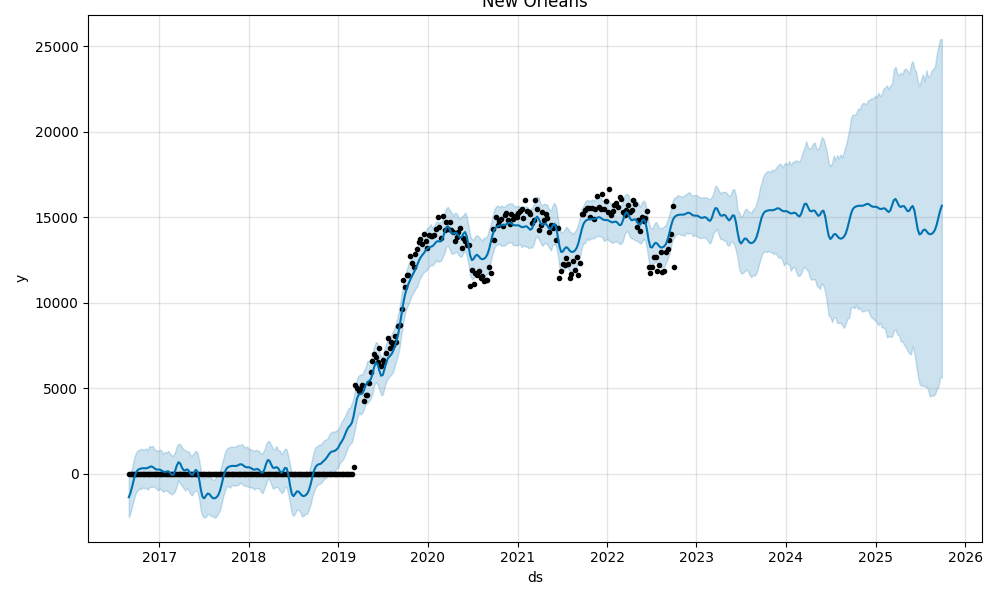

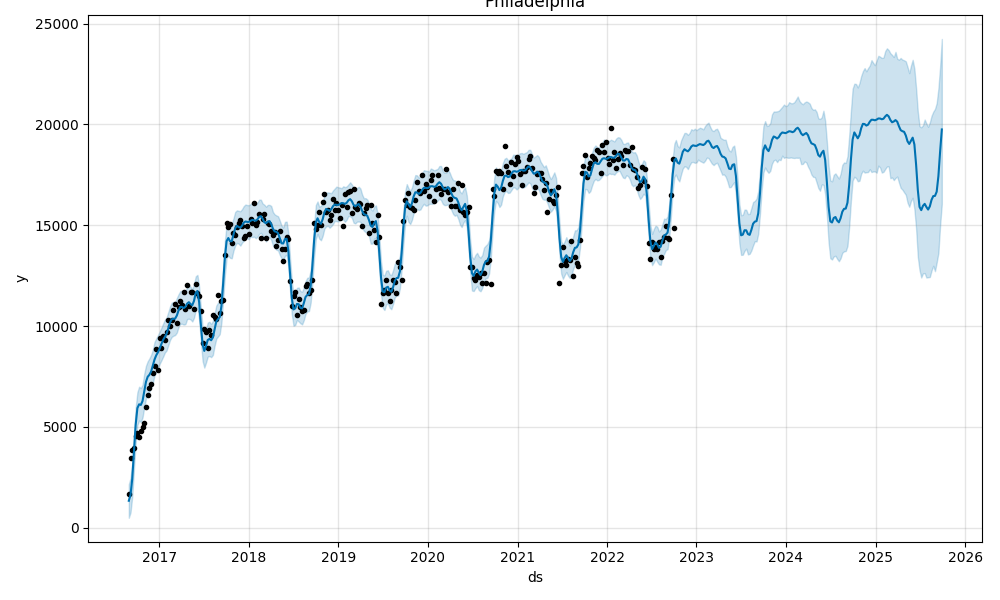

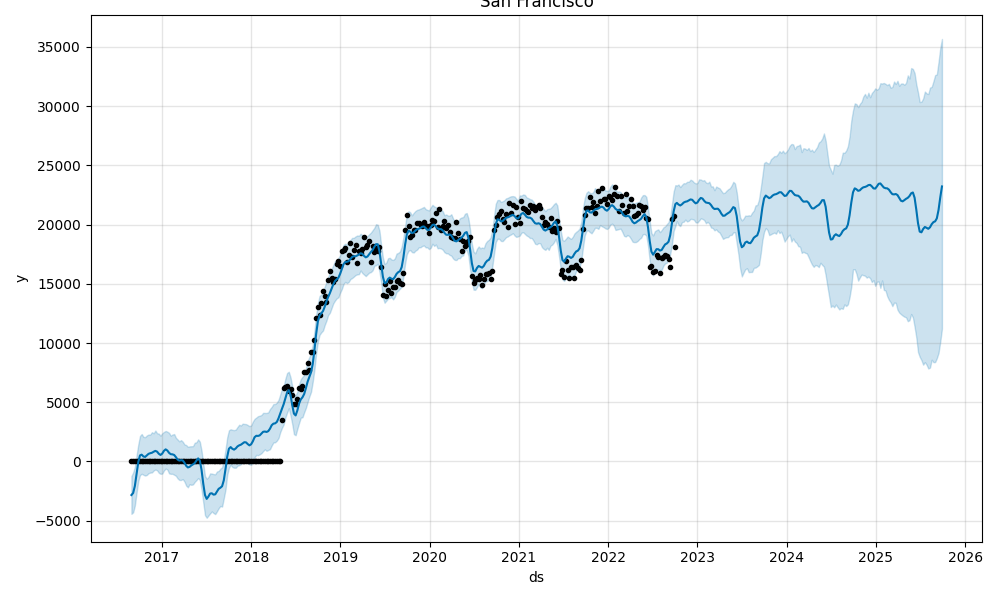

In [37]:
for location in locations:
    models[location].plot(forecasts[location])
    plt.title(location)

Now using the dbt models

In [38]:
models = s.table(f"{schema}.forecast_train_py").to_pandas()
models.tail()

,trained_at,location,model
50,1665318178808607,Brooklyn,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp..."
51,1665318178808607,Chicago,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp..."
52,1665318178808607,New Orleans,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp..."
53,1665318178808607,Philadelphia,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp..."
54,1665318178808607,San Francisco,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp..."


In [39]:
locations = sorted(list(models["location"].unique()))
locations

['Brooklyn', 'Chicago', 'New Orleans', 'Philadelphia', 'San Francisco']

In [40]:
most_recent_trained_at = models["trained_at"].max()
most_recent_trained_at

1665318178808607

In [41]:
models = models[models["trained_at"] == most_recent_trained_at]
models

,trained_at,location,model
50,1665318178808607,Brooklyn,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp..."
51,1665318178808607,Chicago,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp..."
52,1665318178808607,New Orleans,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp..."
53,1665318178808607,Philadelphia,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp..."
54,1665318178808607,San Francisco,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp..."


In [42]:
models = {
    location: model_from_json(models[models["location"] == location]["model"].iloc[0])
    for location in locations
}
models

{'Brooklyn': <prophet.forecaster.Prophet at 0x7f634e576b20>,
 'Chicago': <prophet.forecaster.Prophet at 0x7f6326d60910>,
 'New Orleans': <prophet.forecaster.Prophet at 0x7f6326dc1280>,
 'Philadelphia': <prophet.forecaster.Prophet at 0x7f63269d8130>,
 'San Francisco': <prophet.forecaster.Prophet at 0x7f6326d7d880>}

In [43]:
forecasts = s.table(f"{schema}.forecast_score_py").to_pandas()
forecasts.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,location
2370,1756598400000000,22345.991173,8163.176824,32865.640830,10139.710463,35005.428202,-2065.696445,-2065.696445,-2065.696445,-2065.696445,-2065.696445,-2065.696445,0.0,0.0,0.0,20280.294729,San Francisco
2371,1757203200000000,22357.818751,7998.131607,33354.047313,9983.430334,35196.948852,-1826.043326,-1826.043326,-1826.043326,-1826.043326,-1826.043326,-1826.043326,0.0,0.0,0.0,20531.775425,San Francisco
2372,1757808000000000,22369.646329,8735.398407,34243.857588,9845.043806,35334.698962,-1128.095030,-1128.095030,-1128.095030,-1128.095030,-1128.095030,-1128.095030,0.0,0.0,0.0,21241.551299,San Francisco
2373,1758412800000000,22381.473907,9467.452348,35536.930028,9718.062900,35475.802907,-87.275199,-87.275199,-87.275199,-87.275199,-87.275199,-87.275199,0.0,0.0,0.0,22294.198708,San Francisco
2374,1759017600000000,22393.301485,10399.668555,36465.088605,9619.408979,35643.210360,834.672738,834.672738,834.672738,834.672738,834.672738,834.672738,0.0,0.0,0.0,23227.974223,San Francisco


In [44]:
# hack -- datetime in Snowpark/Pandas funkiness
forecasts["ds"] /= 1e6
forecasts["ds"] = pd.to_datetime(forecasts["ds"], unit="s")
forecasts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2375 entries, 0 to 2374
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          2375 non-null   datetime64[ns]
 1   trend                       2375 non-null   float64       
 2   yhat_lower                  2375 non-null   float64       
 3   yhat_upper                  2375 non-null   float64       
 4   trend_lower                 2375 non-null   float64       
 5   trend_upper                 2375 non-null   float64       
 6   additive_terms              2375 non-null   float64       
 7   additive_terms_lower        2375 non-null   float64       
 8   additive_terms_upper        2375 non-null   float64       
 9   yearly                      2375 non-null   float64       
 10  yearly_lower                2375 non-null   float64       
 11  yearly_upper                2375 non-null   float64     

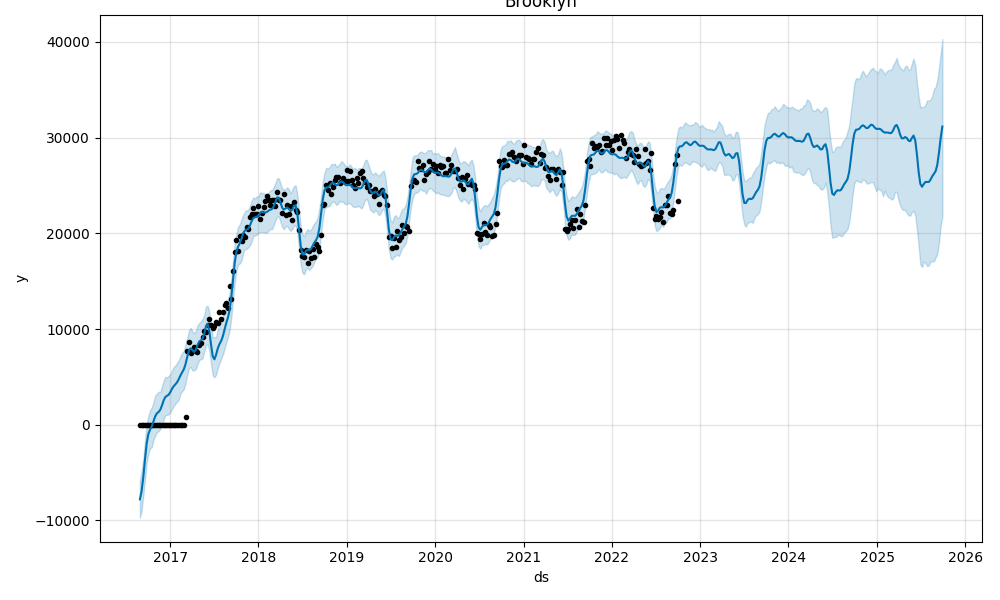

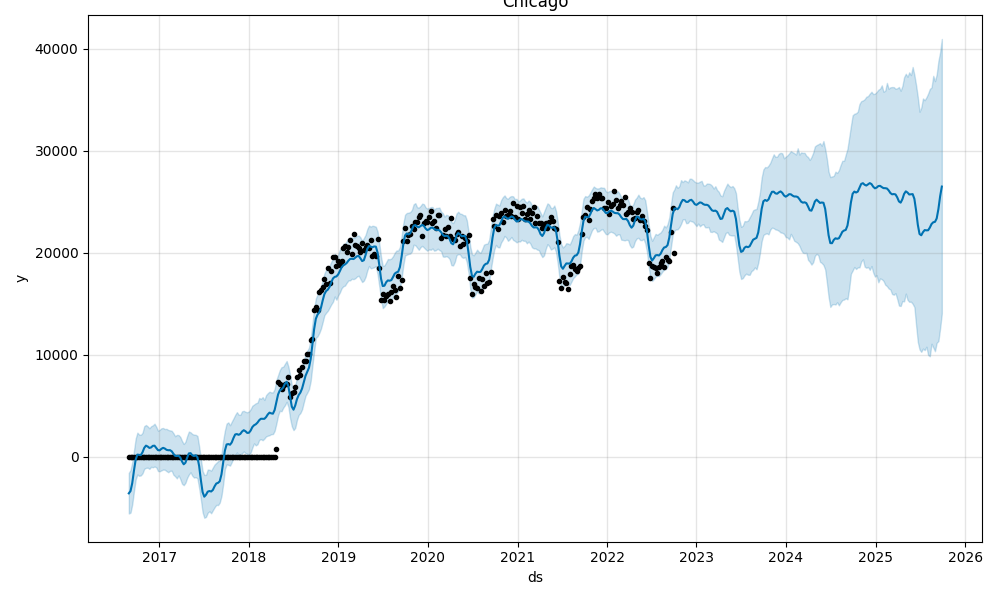

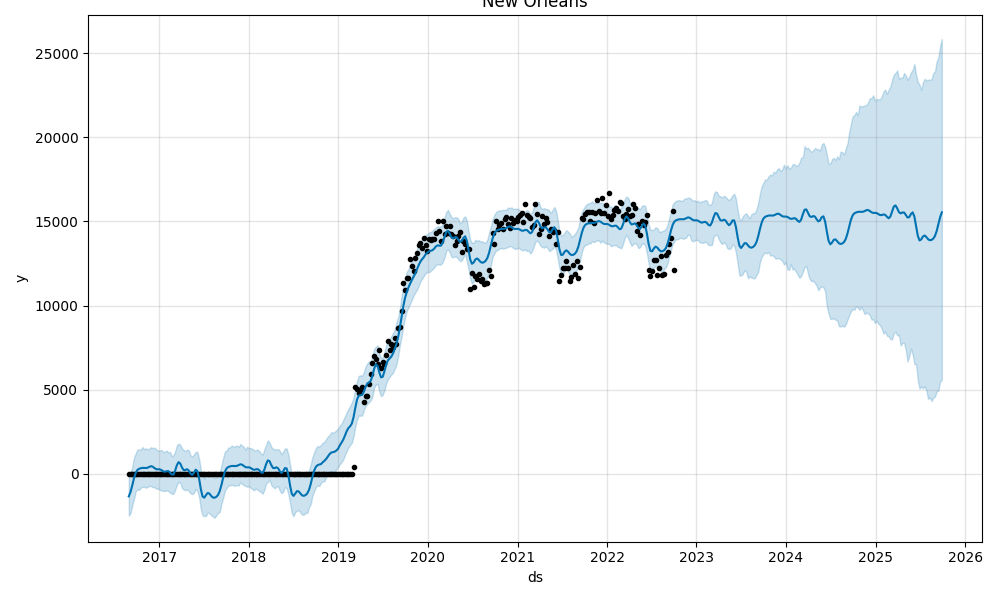

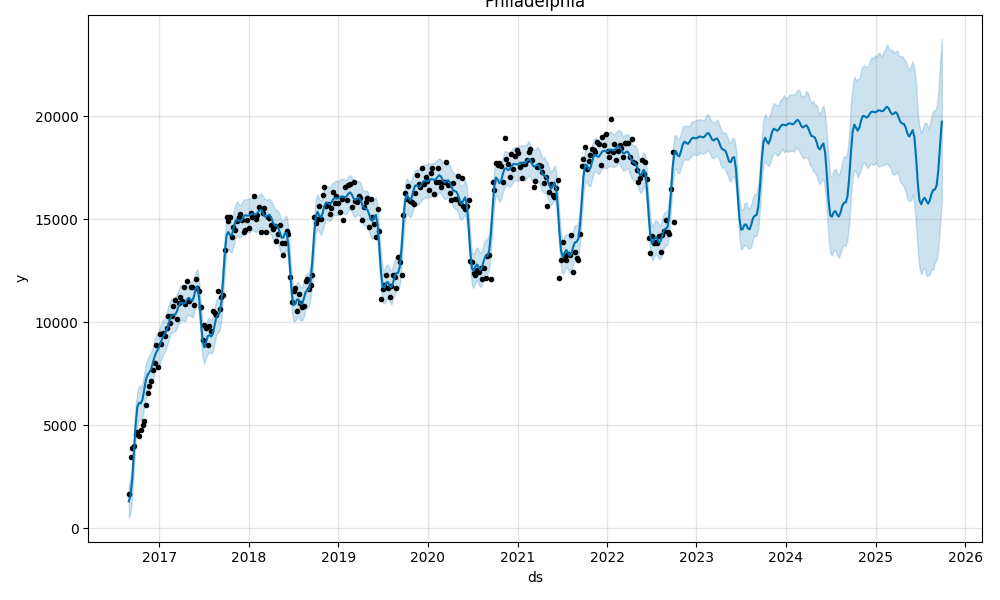

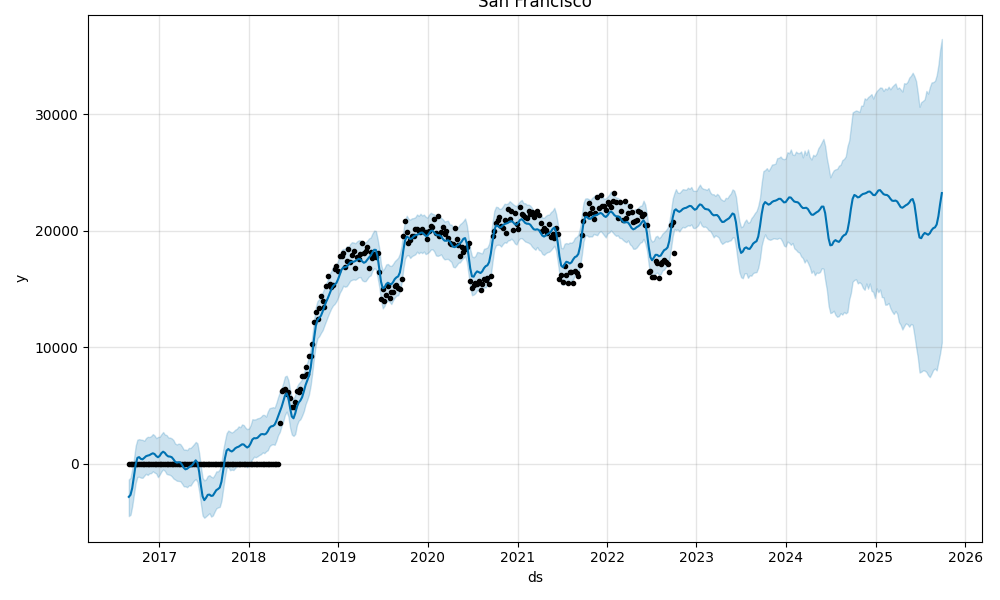

In [45]:
for location in locations:
    models[location].plot(forecasts[forecasts["location"] == location])
    plt.title(location)